In [1]:
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
import csv
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier
from sklearn.linear_model import LogisticRegression
from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import RandomizedSearchCV
from sklearn.model_selection import cross_val_score
from sklearn.metrics import f1_score, confusion_matrix, ConfusionMatrixDisplay
import joblib

import sys
sys.path.append('../code/')
from message_preprocessor import MessagePreprocessor
import constants as c

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\ngoca\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\ngoca\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\ngoca\AppData\Roaming\nltk_data...


In [2]:
df = pd.read_csv(c.RAW_FILE, header=None, delimiter='\t', quoting=csv.QUOTE_NONE)
df.columns = ['label', 'body']
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 5574 entries, 0 to 5573
Data columns (total 2 columns):
 #   Column  Non-Null Count  Dtype 
---  ------  --------------  ----- 
 0   label   5574 non-null   object
 1   body    5574 non-null   object
dtypes: object(2)
memory usage: 87.2+ KB


SMSSpamCollection file read as DataFrame with 5574 entries(as referenced in raw file). label column is the intended classification (spam/ham) and body column contains the string of messages

In [3]:
len(df.dropna(how='any', axis=1))

5574

No missing values in the dataframe

Text(0, 0.5, 'Number of cases')

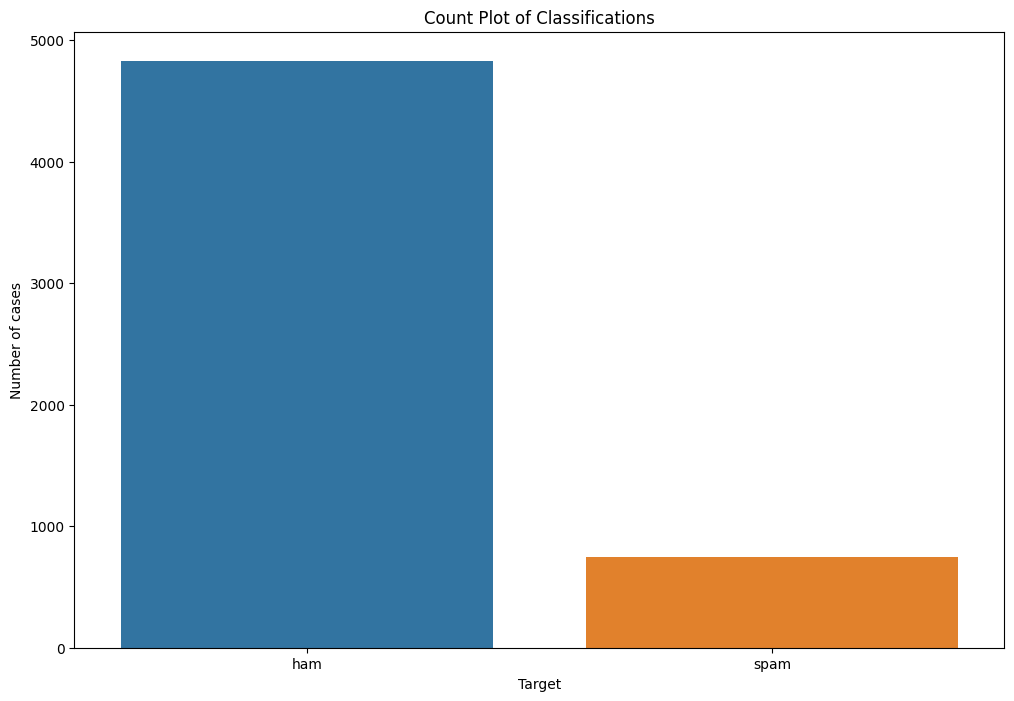

In [4]:
plt.figure(figsize=(12,8))
fg = sns.countplot(x= df["label"])
fg.set_title("Count Plot of Classifications")
fg.set_xlabel("Target")
fg.set_ylabel("Number of cases")

NOTE: The number of spam classes is significantly lower than the number of ham. This is a case of data imbalance as expected from spam classification problems. We may need to treat this via synthetic oversampling later.

FEATURE ENGINEERING

In [5]:
df['body_len'] = df['body'].str.len()
df.describe()

,body_len
count,5574.000000
mean,80.478292
std,59.848302
min,2.000000
25%,36.000000
50%,62.000000
75%,122.000000
max,910.000000


The mean body_len is 80.4 and we have values around 910. This indicates the presence outliers. Let's remove data that are 3(default) standard deviattion away (80.49 + 3 * 59.84)=260.01 from the central value.

In [6]:
df = df[df['body_len'] <= 260]
len(df)

5510

We lost 64 rows in doing so, but that should be fine as the outliers can mess up our data/model

<Figure size 1200x500 with 0 Axes>

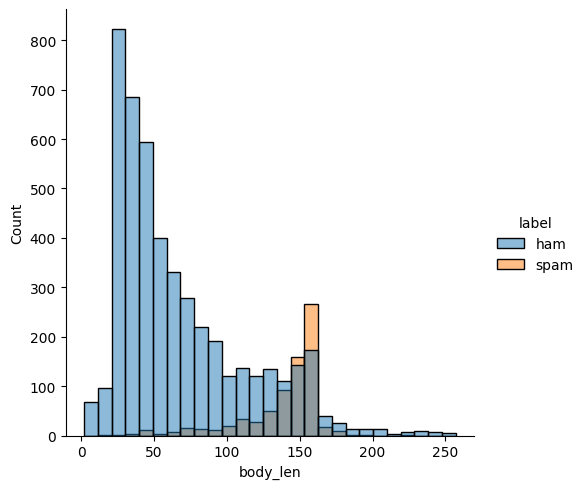

In [7]:
import seaborn as sns
plt.figure(figsize=(12,5))
fg = sns.displot(df, x='body_len', hue='label', kde=False)

Majority of the ham messages are shorter than spam messages. This feature may prove to be worthwhile in the latter steps

DATA PREPROCESSING - Involves several steps to prepare the data into a format compatible with ML algorithms/frameworks
* Data Cleaning
* Tokenization
* Removing Stop Words
* Lemmatization
* Vectorization

DATA PREPROCESSING - Data Cleaning\
When working the NLP we want to remove/drop special characters in the dataset because:
* They hold little to no information.
* They may introduce noise
* Dropping them would reduce the number of vocabulary that our model has to "learn". This makes it easier to arrive at an optimal solution

Another best practice is to lowercase all characters. That way the model won't have treat the same word with different captialization as different entities.

To do this I packaged the preprocessig functionalities we need into a class which we can reuse in the inference code.

In [8]:
df['body'].tail(20)

5553    Wen did you get so spiritual and deep. That's ...
5554    Have a safe trip to Nigeria. Wish you happines...
5555                          Hahaha..use your brain dear
5556    Well keep in mind I've only got enough gas for...
5557    Yeh. Indians was nice. Tho it did kane me off ...
5558    Yes i have. So that's why u texted. Pshew...mi...
5560                               Sorry, I'll call later
5561    if you aren't here in the next  &lt;#&gt;  hou...
5562                    Anything lor. Juz both of us lor.
5563    Get me out of this dump heap. My mom decided t...
5564    Ok lor... Sony ericsson salesman... I ask shuh...
5565                                  Ard 6 like dat lor.
5566    Why don't you wait 'til at least wednesday to ...
5567                                         Huh y lei...
5568    REMINDER FROM O2: To get 2.50 pounds free call...
5569    This is the 2nd time we have tried 2 contact u...
5570                 Will ü b going to esplanade fr home?
5571    Pity, 

Above is the raw version of the message body. Observations:
* There numbers of special characters.
* At index 5561 we can also see the body to have html characters.
* Message body is mixed-case

In [9]:
message_preprocessor = MessagePreprocessor()
df['clean_body'] = message_preprocessor.clean_text(df['body'])

In [10]:
df['clean_body'] .tail(20)

5553    wen did you get so spiritual and deep  that s ...
5554    have a safe trip to nigeria  wish you happines...
5555                          hahaha  use your brain dear
5556    well keep in mind i ve only got enough gas for...
5557    yeh  indians was nice  tho it did kane me off ...
5558    yes i have  so that s why u texted  pshew   mi...
5560                               sorry  i ll call later
5561    if you aren t here in the next       hours imm...
5562                    anything lor  juz both of us lor 
5563    get me out of this dump heap  my mom decided t...
5564    ok lor    sony ericsson salesman    i ask shuh...
5565                                  ard   like dat lor 
5566    why don t you wait  til at least wednesday to ...
5567                                         huh y lei   
5568    reminder from o   to get      pounds free call...
5569    this is the  nd time we have tried   contact u...
5570                 will   b going to esplanade fr home 
5571    pity  

After running remove_special_character(), we can see that the special characters (including the html characters) are removed and all of the characters are lowercased.

DATA PREPROCESSING - Tokenization\
The goal of this step is to split the messages into individual words(tokens). This makes it easier to easier to vectorize(convert to numerical value) the message data

In [11]:
df['tokenized_text'] = message_preprocessor.tokenize(df['clean_body'])
df['tokenized_text'].head()

0    [go, until, jurong, point, crazy, available, o...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, in, a, wkly, comp, to, win, fa, ...
3    [u, dun, say, so, early, hor, u, c, already, t...
4    [nah, i, don, t, think, he, goes, to, usf, he,...
Name: tokenized_text, dtype: object

DATA PREPROCESSING - Stop Words\
Stop words are words that are used to make the grammar work but do not really hold much information especially in NLP. Removing these would simplify the things our algorithm has to learn.

In [12]:
df['go_text'] = message_preprocessor.remove_stop_words(df['tokenized_text'])
df['go_text'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4       [nah, think, goes, usf, lives, around, though]
Name: go_text, dtype: object

DATA PREPROCESSING - LEMMATIZATION\
Lemmatization and stemming are techniques to convert words into their rootword (e.g., horses->horse). Doing so, would reduce the number of distinct words that the ML has to process.\
Lemmatization takes the context into consideration while stemming is a little naive. Stemming the word caring would result to car, while lemmatization produces care. For this reason, we will use lemmatization.\
NOTE: Lemmatization is computationally more expensive than stemming.


In [13]:
df['lemmatized_text'] = message_preprocessor.lemmatize(df['go_text'])
df['lemmatized_text'].head()

0    [go, jurong, point, crazy, available, bugis, n...
1                       [ok, lar, joking, wif, u, oni]
2    [free, entry, wkly, comp, win, fa, cup, final,...
3        [u, dun, say, early, hor, u, c, already, say]
4          [nah, think, go, usf, life, around, though]
Name: lemmatized_text, dtype: object

DATA PREPROCESSING - VECTORIZATION\
The previous preprocessing steps were mostly focused on trimming down the messages to only contain the most important words. However, machine learning algorithms are not compatible with strings, that is why we need to convert it to numbers.\

To do this, we will use TF-IDF which stands for Term Frequency - Inverse Document Frequency.
* Term Frequency - the number of times a word appears in a sentence.
* Inverse Document Frequency - the number of times the word appears in the whole dataset.


Essentially, words that appears a lot in a sentence, but is rare across all documents will have a large value. Meaning they hold a lot of context for that sentence.

In [14]:
(vectorizer, vectorized_text) = message_preprocessor.vectorize(df['lemmatized_text'])
X = vectorized_text

In [15]:
#Convert spam/ham labels to 1/0
label_encoder = LabelEncoder()
y = label_encoder.fit_transform(df["label"])

Shortlisting Models\
The goal here is to quickly train different classifiers against our data. The best performing one will then be fine-tuned.\
To do this:
* Split the dataset into train and test groups. Make sure the test data is never used for training.
* fit() different instances of the classifiers
* evaluate performance via k-fold cross validation using f1-score(since this is a classification problem and we have no preference between False Positives and False Negatives)

In [16]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [17]:
#Testing on the following classifiers
classifiers = [XGBClassifier(),
               RandomForestClassifier(),
               SVC(),
               LogisticRegression()]
for cls in classifiers:
    cls.fit(X_train, y_train)


In [18]:
# Dictionary of pipelines and model types for ease of reference
pipe_dict = {0: "XGB", 1: "RandomForest", 2: "SVC", 3: "Log"}
# Cossvalidation 
for i, model in enumerate(classifiers):
    cv_score = cross_val_score(model, X_train, y_train, scoring="f1", cv=10)
    print("%s: %f " % (pipe_dict[i], cv_score.mean()))

XGB: 0.908009 
RandomForest: 0.919382 
SVC: 0.898801 
Log: 0.839271 


The RandomForest classifier looks promising. Let's see if we can improve it further.

Since we are working on an imbalanced dataset, let's try to treat with a Synthetic Minority Oversampling Technique(SMOTE). This will add more cases of minority spam label, and will theoretically help our model familiarize those data better. \
We can package SMOTE and our classifier in a sklearn pipeline so that SMOTE will only be applied during training and not in validation, testing and inference.

In [19]:
model = Pipeline(
    steps = [('sampling', SMOTE()),('classification', RandomForestClassifier())]
)
model.fit(X_train, y_train)
cv_score = cross_val_score(model, X_train, y_train, scoring="f1", cv=5)
print(cv_score.mean())

0.9229926239484334


Looks like the SMOTE gave us a little bit of performance boost. Let's keep it.

Another approach is to fine tune the hyperparameters(learning parameters) of our model. On the previous training steps, we have been using the default values. Let's try to explore different combinations of these parameters via RandomizedSearchCV.

In [ ]:
model = Pipeline(
    steps = [('sampling', SMOTE()),('classification', RandomForestClassifier())]
)
rfc_params = {
    'classification__bootstrap': [True, False],
    'classification__max_depth': [10, 20, 30, 40, 50, 60, 70, 80, 90, 100, None],
    'classification__max_features': ['auto', 'sqrt'],
    'classification__min_samples_leaf': [1, 2, 4],
    'classification__min_samples_split': [2, 5, 10],
    'classification__n_estimators': [200, 400, 600, 800, 1000, 1200, 1400, 1600, 1800, 2000]
 }
rfc_gs = RandomizedSearchCV(model, rfc_params, cv=5, verbose=3, n_jobs=-1, scoring='f1', n_iter=2)

rfc_gs.fit(X_train, y_train)
cv_results = pd.DataFrame(rfc_gs.cv_results_)
cv_results.sort_values(by='rank_test_score').head()

MODEL EVALUATION\
In the previous steps we trained different models and fine tuned the RandomForestClassifier entirely on the training set. Now it is time to test the model against data that it has never seen before. This is why we separated 20% of our data at the beginning of the training phase.

In [20]:
preds = model.predict(X_test)

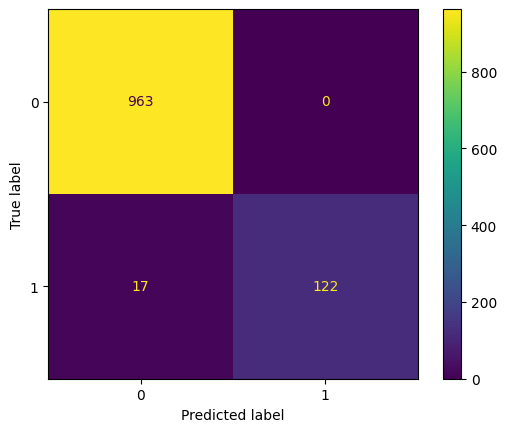

In [21]:
cm = confusion_matrix(y_test, preds)
ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model.classes_).plot()

In [22]:
f1_score(y_test, preds)

0.9348659003831418

CONCLUSION:

Confusion Matrix:
* True Positives(124) - The number of spams correctly predicted as spams, we want to maximize this
* True Negatives(963) - The number of hams correctly predicted as hams, we want to maximize this
* False Positives(0)  - The number of hams mispredicted as spams, we want to minimize this
* False Negatives(15) - The number of spams mispredicted as hams, we want to minimize this

F1_SCORE(0.943) - Ideally 1

In terms of accuracy of classification, I'd say this is a pretty good model since the F1 Score is close to 1. Having no false positives is also a good tradeoff against a few number of false positives. Of course it is ideal to have 0 false positives, but I think people would prefer to receive few spams than to have their messages blocked for no reason.

Before we forget, let's save our trained models into .joblib files so we can use them later

In [23]:
joblib.dump(vectorizer, c.VECTORIZER_JOBLIB)
joblib.dump(model, c.CLASSIFIER_JOBLIB)
joblib.dump(label_encoder, c.LABEL_ENCODER_JOBLIB)

['../model/label_encoder.joblib']